In [40]:
%matplotlib inline
import numpy as np
import pysal as ps
import random as rdm
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import json
import geojson as gj
import folium as fl
from pysal.contrib.viz import folium_mapping as fm
from pylab import rcParams
rcParams['figure.figsize'] = 20,20


from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_samples, silhouette_score

Load shapefile of Denver census tracts, which contains American Community Survey demographic data. The geographies will be used for mapping, while the attribute table will be put into a pd dataframe. These will be the variables used for clustering.

The data come from 2009-2013 5-year estimates at the tract level, availible through the Denver Open Data catalog: https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-american-community-survey-tracts-2009-2013

In [11]:
den = gpd.read_file('ACS/ACS.shp')

den_data = ps.pdio.read_files('ACS/ACS.shp')

We can plot a map of the census tracts as follows. For now, we won't consider any data. This will just be a univariate map to get practice with displaying geographies.

[]

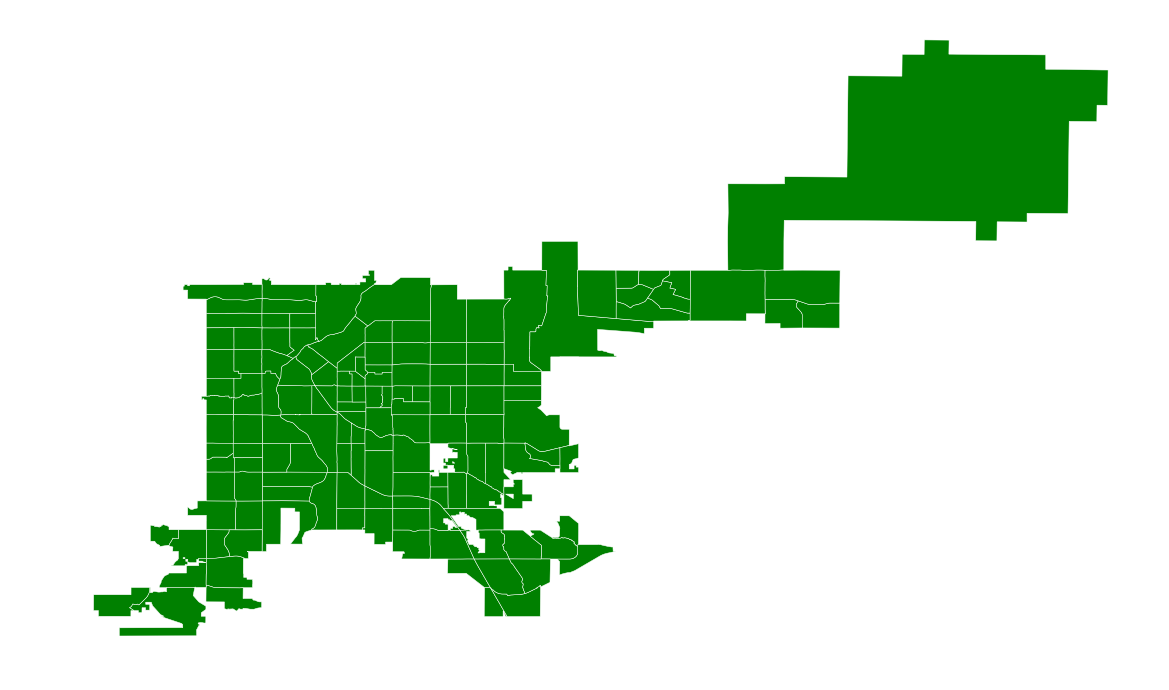

In [8]:
den['constant'] = 1
p = den.plot(color='green', linewidth=0.5, edgecolor='white')
p.axis('off')
p.plot()

Each of these tracts will be a data point. Associated with it are several demographic variables. These include racial composition, age composition, primary languages spoken, household income brackets, family structure, highest level of education, years built for phsyical properties, and rates of property vacancies. You can see variable names below. Using the link above, you can get more specific variable descriptions in the metadata file.

In [13]:
print(list(den_data))

['STFID', 'STFID_NUM', 'TRACTCE10', 'ALAND10', 'AWATER10', 'LOGRECNO', 'GEO_NAME', 'TTL_POPULA', 'HISPANIC_O', 'WHITE', 'BLACK', 'NATIVE_AME', 'ASIAN', 'HAWAIIAN_P', 'OTHER_RACE', 'TWO_OR_MOR', 'PCT_HISPAN', 'PCT_WHITE', 'PCT_BLACK', 'PCT_NATIVE', 'PCT_ASIAN', 'PCT_HAWAII', 'PCT_OTHERR', 'PCT_TWOORM', 'MALE', 'FEMALE', 'AGE_LESS_5', 'AGE_5_TO_9', 'AGE_10_TO_', 'AGE_15_TO_', 'AGE_0_TO_9', 'AGE_10_TO1', 'AGE_20_TO_', 'AGE_30_TO_', 'AGE_40_TO_', 'AGE_50_TO_', 'AGE_60_TO_', 'AGE_70_TO_', 'AGE_80_PLU', 'AGELESS18', 'AGE65PLUS', 'PCT_AGELES', 'PCT_AGE65P', 'MEDIAN_AGE', 'MEDIAN_A_1', 'MEDIAN_A_2', 'TTL_AGE_3_', 'ENROLLED_I', 'NURSERY_OR', 'KINDERGART', 'GRADES_1_T', 'GRADES_5_T', 'GRADES_9_T', 'COLLEGE_UN', 'GRADUATE_S', 'NOT_ENROLL', 'TOTAL_COMM', 'COMMUTE_LE', 'COMMUTE_15', 'COMMUTE_30', 'COMMUTE_45', 'COMMUTE_60', 'TTLPOP_25P', 'LESS_THAN_', 'HSGRAD_OR_', 'SOMECOLLEG', 'BACHELORS_', 'TTLPOP_5PL', 'ONLY_ENGLI', 'SPANISH_LN', 'FRENCH_LNG', 'FRENCH_CRE', 'ITALIAN_LN', 'PORTUGESE_', 'GERMAN_L

For example, we can look at univariate maps as follows. The below map describes the median household income of each census tract. It is split by quantiles.

[]

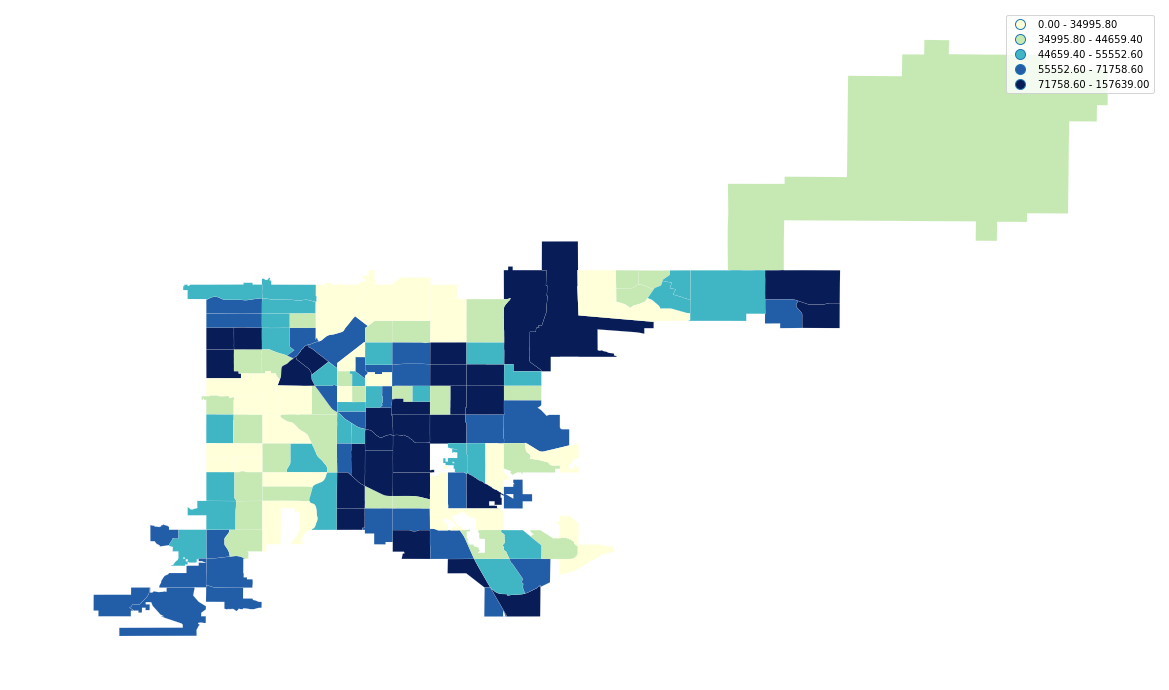

In [14]:
quant = den.plot(column='MED_HH_INC', scheme='QUANTILES', k=5, cmap='YlGnBu', linewidth=0.1, edgecolor='white',legend=True)
quant.axis('off')
quant.plot()

This is certainly one way of understanding the social landscape of Denver. But there is a lot more to it than single variables. There are several ways of looking at multivariate patterns. Principal components analysis, for example, could tell us what the most distinguishing combinations of variables are. But PCA isn't very interpretable, and doesn't make easily understood maps like the one above. In order to get an intuitive, and mappable way of combining several demographic traits, we can use cluster analysis. 

While there are much fancier methods, k-means has been used successfully for clustering ACS-type data in a lot of published work, so it seems like a reasonbable starting point. Essentially, the results from k-means will categorize our census tracts into "types" of places. The census tracts within each cluster will have similar demographic characteristics to eachother. When running k-means, we are not explicitely considering the location of each tract. We will map our results later in order to determine spatial patterns.

In this case, we can use theoretical unserstanding and some common sense to guide feature selection. What aspects make the character of, and quality-of-life in, one neighborhood different from another? As a starting point, let's consider the variables associated with race, age, education, language, family structure, and wealth.

In [26]:
race = ['PCT_HISPAN','PCT_WHITE','PCT_BLACK','PCT_NATIVE','PCT_ASIAN','PCT_HAWAII','PCT_OTHERR']
age = ['AGE_0_TO_9','AGE_10_TO1','AGE_20_TO_','AGE_30_TO_','AGE_40_TO_','AGE_50_TO_','AGE_60_TO_','AGE_70_TO_','AGE_80_PLU']
edu = ['HSGRAD_OR_','BACHELORS_']
lang = ['ONLY_ENGLI', 'SPANISH_LN']
family = ['MARRIED_CO','FAMILY_HOU','NONFAMILY_']
wealth = ['MED_HH_INC']
columns = race + age + edu + lang + family + wealth

Before running k-means, let's first scale our data (we will be running the clustering on z-scores, rather than the raw data since each of our variables are measured on a different scale).

In [35]:
den_data_scaled = scale(den_data[columns])
print(den_data_scaled.shape)

(144, 24)


Because we don't have labels for this data set (the clusters are things we're finding, not trying to recreate), we have a limited selection of metrics for determining our parameters. We will identify an appropriate value for $k$ in two ways:
- The value of $k$ should be a small enough number that we get interpretable and mappable cluster assignments. The goal is to reduce data complexity in order to make spatial patterns aparent and understandable. For this reason, we will test values of $k$ between 3 and 7.
- We will select an appropriate value for $k$ using sillhouette analysis. The sillhouette coefficient desribes how close the cluster is to the decision boundary. Higher sillhouette values indicate a better model.

In [45]:

k_options = [3, 4, 5, 6, 7]

for k in k_options:
    clusterer_k = KMeans(n_clusters=k, init = 'k-means++', random_state=1234)
    clusterer_spec = SpectralClustering(n_clusters=k, random_state=1234)
    clusterer_gmm = GaussianMixture(n_components = k)
    
    cluster_labels_k = clusterer_k.fit_predict(den_data_scaled)
    cluster_labels_spec = clusterer_spec.fit_predict(den_data_scaled)
    cluster_trained_gmm = clusterer_gmm.fit(den_data_scaled)
    cluster_labels_gmm = cluster_trained_gmm.predict(den_data_scaled)
    
    avg_sil_k = silhouette_score(den_data_scaled, cluster_labels_k)
    avg_sil_spec = silhouette_score(den_data_scaled, cluster_labels_spec)
    avg_sil_gmm = silhouette_score(den_data_scaled, cluster_labels_gmm)
    
    print("For ", k, "clusters,")
    print("\t the average k-means silhouette score is : " , avg_sil_k)
    print("\t the average spectral silhouette score is : " , avg_sil_spec)
    print("\t the average GMM silhouette score is : " , avg_sil_gmm)
    
    

For  3 clusters,
	 the average k-means silhouette score is :  0.190290286554
	 the average spectral silhouette score is :  -0.173374698134
	 the average GMM silhouette score is :  0.189694929209
For  4 clusters,
	 the average k-means silhouette score is :  0.164624583488
	 the average spectral silhouette score is :  -0.18651816701
	 the average GMM silhouette score is :  0.143968921487
For  5 clusters,
	 the average k-means silhouette score is :  0.155692576806
	 the average spectral silhouette score is :  -0.225737777438
	 the average GMM silhouette score is :  0.165157499486
For  6 clusters,
	 the average k-means silhouette score is :  0.169632215689
	 the average spectral silhouette score is :  -0.249537932168
	 the average GMM silhouette score is :  0.153404343423
For  7 clusters,
	 the average k-means silhouette score is :  0.163613193031
	 the average spectral silhouette score is :  -0.284292005296
	 the average GMM silhouette score is :  0.159477741119


Next, visualize k-means results on a map. 

[]

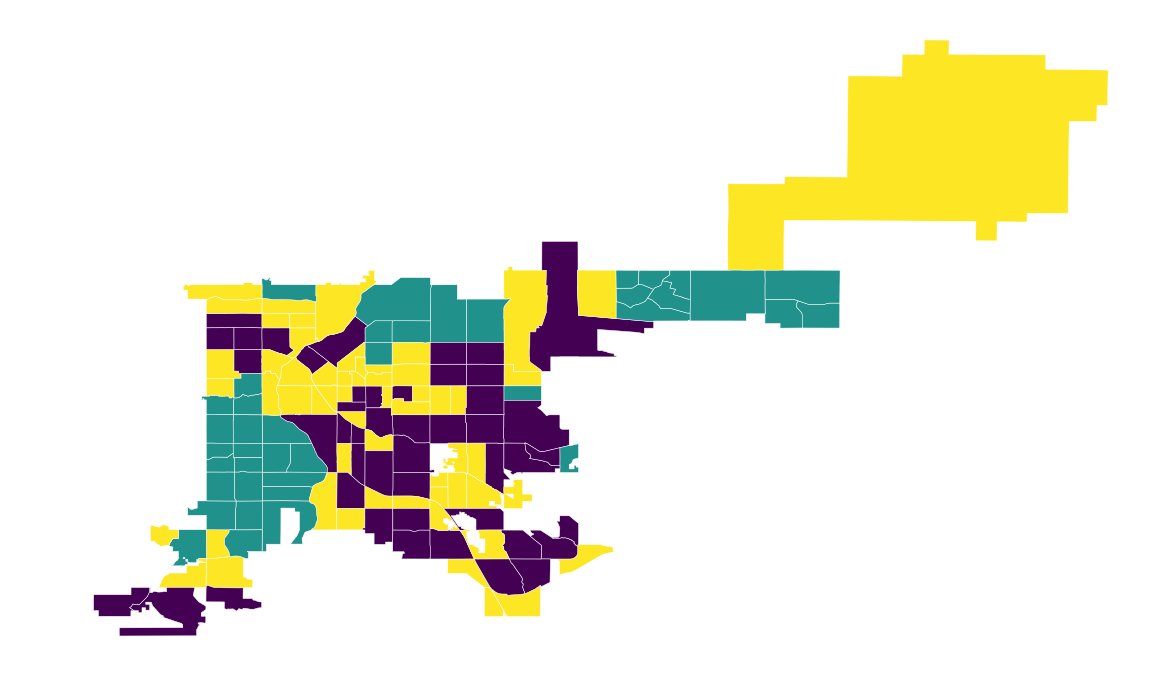

In [60]:
clusterer_k = KMeans(n_clusters=3, init = 'k-means++', random_state=1234)
cluster_labels_k = clusterer_k.fit_predict(den_data_scaled)


den['cluster'] = cluster_labels_k
p = den.plot(column='cluster', linewidth=0.5, edgecolor='white')
p.axis('off')
p.plot()